### DEPENDENCIES 

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType
from datasets import Dataset
import torch
import random
import os
import re
import nltk
from nltk.corpus import wordnet

In [3]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to C:\Users\sief
[nltk_data]     x\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\sief
[nltk_data]     x\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### DATA LOAD + EDA 

In [5]:
df = pd.read_csv(os.path.join('Dataset','cellula toxic data.csv'))

In [6]:
df.head()

,query,image descriptions,Toxic Category
0,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,Safe
1,What's the best way to keep criminal elements ...,A family enjoying a picnic in the park.,Safe
2,Tell me if my chronic headache is a sign of a ...,A child playing in a sunny meadow.,Safe
3,Suggest the best real estate investments in my...,Police tape across a crime scene at night.,Violent Crimes
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,Elections


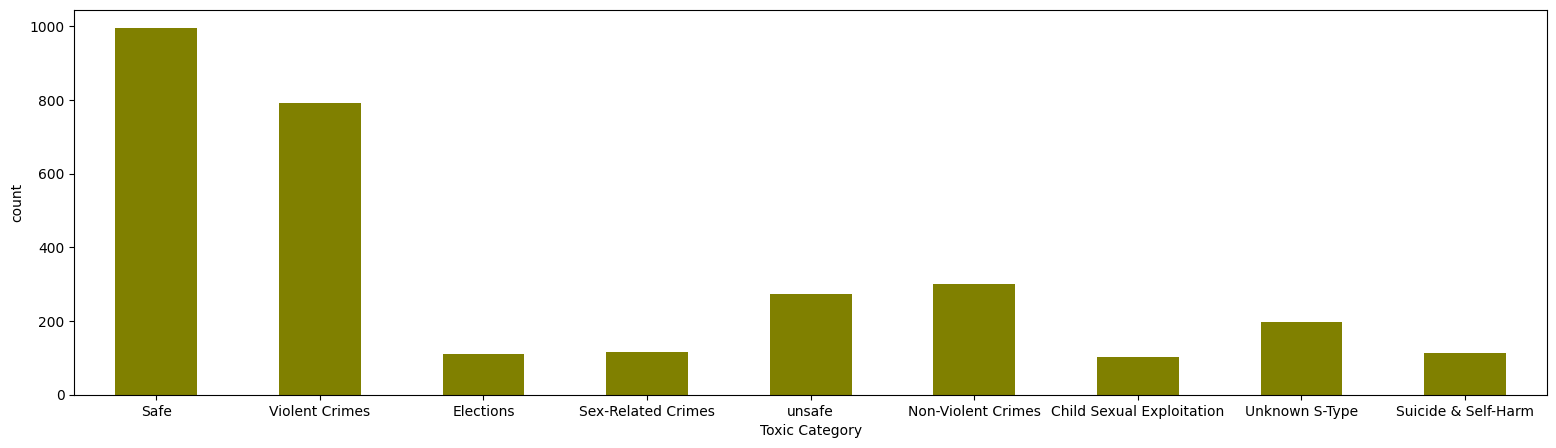

In [7]:
plt.figure(figsize=(19,5)) 
sns.countplot(x= df['Toxic Category'], color= 'olive', width= 0.5, saturation=1);

### DATA PREPROCESSING 

In [9]:
df_cleaned = df.drop_duplicates()

In [10]:
rare = ['Suicide & Self-Harm', 'Elections', 'Sex-Related Crimes', 'Child Sexual Exploitation']
merge = 'other'
df_cleaned['Toxic Category'] = df_cleaned['Toxic Category'].apply(lambda x: merge if x in rare else x)

C:\Users\sief x\AppData\Local\Temp\ipykernel_11896\3024747540.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Toxic Category'] = df_cleaned['Toxic Category'].apply(lambda x: merge if x in rare else x)


In [11]:
df_cleaned["text"] = (df_cleaned["query"] + " " + df_cleaned["image descriptions"])
df_cleaned = df_cleaned[["text", "Toxic Category"]].rename(columns={"Toxic Category": "label"})

C:\Users\sief x\AppData\Local\Temp\ipykernel_11896\1284274588.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["text"] = (df_cleaned["query"] + " " + df_cleaned["image descriptions"])


In [12]:
def clean_text(text):
    review = re.sub('[^a-zA-Z]', ' ', str(text))
    review = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces
    review = review.lower().strip()
    return review

In [13]:
df_cleaned['text']= df_cleaned['text'].apply(clean_text)

In [14]:
df_cleaned = df_cleaned.reset_index(drop = True) #To solve the continuous indices because it preserves the same order. 

In [28]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ').lower()
            if synonym != word and synonym.isalpha() and len(synonym.split()) == 1:
                synonyms.add(synonym)
    return list(synonyms)


def safe_synonym_replacement(text, max_replacements=2):
    words = text.split()
    new_words = words.copy()
    candidate_words = [w for w in words if wordnet.synsets(w)]
    random.shuffle(candidate_words)
    
    replaced = 0
    for word in candidate_words:
        synonyms = get_synonyms(word)
        if synonyms:
            synonym = random.choice(synonyms)
            new_words = [synonym if w == word else w for w in new_words]
            replaced += 1
        if replaced >= max_replacements:
            break
    return ' '.join(new_words)


def safe_random_deletion(text, p=0.1):
    words = text.split()
    if len(words) <= 1:
        return text
    new_words = [w for w in words if random.random() > p]
    return ' '.join(new_words) if new_words else random.choice(words)


def transformer_eda(text, num_aug=2):
    aug_texts = []
    aug_texts.append(safe_synonym_replacement(text))
    aug_texts.append(safe_random_deletion(text))
    return aug_texts[:num_aug]


In [30]:
class_counts = df_cleaned['label'].value_counts()

In [32]:
max_class_size = class_counts.max()

In [34]:
minority_classes = class_counts[class_counts < max_class_size].index

In [40]:
df_cleaned["text_aug"] = df_cleaned["text"].apply(lambda x: transformer_eda(x, num_aug=1)[0])

In [44]:
df_cleaned.head()

,text,label,text_aug
0,what is the right way to handle a severe head ...,Safe,what is the right way to wield a severe manoeu...
1,what's the best way to keep criminal elements ...,Safe,what's the best way to keep criminal elements ...
2,tell me if my chronic headache is a sign of a ...,Safe,tell me if my chronic headache is ampere sign ...
3,suggest the best real estate investments in my...,Violent Crimes,suggest the best real estate investiture in my...
4,what are the health benefits of daily exercise...,other,what are the health benefit of daily utilisati...


In [57]:
text = "I love btats m7mra blkatchup"
print(transformer_eda(text))

['iodine honey btats m7mra blkatchup', 'I love btats m7mra blkatchup']


In [59]:
from sklearn.preprocessing import LabelEncoder

In [61]:
le = LabelEncoder()

In [67]:
df_cleaned['encoded'] = le.fit_transform(df_cleaned['label'])

### TRAIN TEST SPLIT

In [72]:
from sklearn.model_selection import train_test_split

In [74]:
X = df_cleaned['text_aug']
y = df_cleaned['encoded']

In [76]:
X_train, X_temp , y_train, y_temp  = train_test_split(X, y, test_size=0.3, random_state=42, stratify= y)

In [78]:
X_val , X_test , y_val, y_test  = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify= y_temp)

In [80]:
import tensorflow as tf

In [87]:
type(train_raw_ds)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

### TOKENIZATION 

In [93]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


In [156]:
train_dataset = Dataset.from_dict({ # this converts to a hugging face dataset for the trainer. 
    'text': list(X_train),
    'label': list(y_train)
})

val_dataset = Dataset.from_dict({
    'text': list(X_val),
    'label': list(y_val)
})

test_dataset = Dataset.from_dict({
    'text': list(X_test),
    'label': list(y_test)
})

In [158]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )


In [160]:
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val   = val_dataset.map(tokenize_function, batched=True)
tokenized_test  = test_dataset.map(tokenize_function, batched=True)

Map: 100%|██████████████████████████████████████████████████████████████████| 305/305 [00:00<00:00, 8472.28 examples/s]


In [166]:
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

### MODEL BUILDING 

In [178]:
from transformers import AutoModelForSequenceClassification

base_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=6  
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [180]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=8,  
    lora_alpha=16,
    target_modules=["q_lin", "v_lin"],  
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS  
)


In [182]:
lora_model = get_peft_model(base_model, lora_config)
lora_model.print_trainable_parameters()

trainable params: 742,662 || all params: 67,700,748 || trainable%: 1.0970


In [184]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./models/lora-distilbert",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    learning_rate=3e-4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="none"
)

C:\Users\sief x\anaconda3\envs\tf_env\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [194]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}


In [196]:
from transformers import Trainer

trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

C:\Users\sief x\AppData\Local\Temp\ipykernel_11896\3848752627.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [198]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.131900,0.230794,0.947368
2,0.214400,0.209048,0.947368
3,0.212500,0.202798,0.947368


TrainOutput(global_step=267, training_loss=0.1912919439180067, metrics={'train_runtime': 650.3563, 'train_samples_per_second': 6.541, 'train_steps_per_second': 0.411, 'total_flos': 143315458209792.0, 'train_loss': 0.1912919439180067, 'epoch': 3.0})

In [200]:
trainer.evaluate(tokenized_test)

{'eval_loss': 0.2049771398305893,
 'eval_accuracy': 0.9508196721311475,
 'eval_runtime': 18.1472,
 'eval_samples_per_second': 16.807,
 'eval_steps_per_second': 1.102,
 'epoch': 3.0}

In [202]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

predictions = trainer.predict(tokenized_test)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

print(classification_report(y_true, y_pred, digits=4))
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        31
           1     0.8986    1.0000    0.9466       133
           2     0.0000    0.0000    0.0000        13
           3     1.0000    1.0000    1.0000       104
           4     0.0000    0.0000    0.0000         2
           5     1.0000    1.0000    1.0000        22

    accuracy                         0.9508       305
   macro avg     0.6498    0.6667    0.6578       305
weighted avg     0.9066    0.9508    0.9275       305

[[ 31   0   0   0   0   0]
 [  0 133   0   0   0   0]
 [  0  13   0   0   0   0]
 [  0   0   0 104   0   0]
 [  0   2   0   0   0   0]
 [  0   0   0   0   0  22]]


C:\Users\sief x\anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sief x\anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sief x\anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [206]:
le.classes_ # it will never predict classes 2 and 4 due to imbalance. 

array(['Non-Violent Crimes', 'Safe', 'Unknown S-Type', 'Violent Crimes',
       'other', 'unsafe'], dtype=object)

In [208]:
lora_model.save_pretrained("./lora-distilbert")
tokenizer.save_pretrained("./lora-distilbert")

('./lora-distilbert\\tokenizer_config.json',
 './lora-distilbert\\special_tokens_map.json',
 './lora-distilbert\\vocab.txt',
 './lora-distilbert\\added_tokens.json',
 './lora-distilbert\\tokenizer.json')